<a href="https://colab.research.google.com/github/kanta-program-account/AnalyzeIris/blob/main/SportsTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 分類か予測かの判断をする.
# 目的変数が0～10の整数であり、クラスラベルに連続量としての意味付けが可能であるため "連続量の予測”とも"多クラス分類”とも解釈できる.
# Irisの延長で解析できると考えたため, テーブルデータの多クラス分類と定義. MSE が線形予測問題であることを示す値と知らず.

In [ ]:
%matplotlib inline
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SequentialFeatureSelector
shap.initjs()

In [ ]:
# カラム数の制限をなくす
pd.set_option('display.max_columns', None)

# 行数の制限をなくす（必要なら）
pd.set_option('display.max_rows', None)

# カラムの幅を広げる（長い文字列を省略せずに表示）
pd.set_option('display.max_colwidth', None)

# 出力全体をスクロールせずに表示（Jupyter Notebookなどで便利）
pd.set_option('display.expand_frame_repr', False)

pd.set_option('display.width', None)  # 横幅を自動調整

np.set_printoptions(threshold=np.inf)

In [ ]:
def RemoveAnomalies(df, column_name: str, min_value: float, max_value: float) -> None:
        """
        Filter the DataFrame to include rows where the specified column's values
        fall within the given range.

        Args:
            column_name (str): Name of the column to filter.
            min_value (float): Minimum value for the filter.
            max_value (float): Maximum value for the filter.

        Returns:
            None
        """

        df_ratio = df[(df[column_name] >= min_value) & (df[column_name] <= max_value)].reset_index(drop=True)

        return df_ratio

from sklearn.model_selection import GridSearchCV, cross_validate, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import DBSCAN

def ProcessGridSearch(X, y, model, feature_names, scaler=None) -> pd.DataFrame:
	"""Performs GridSearchCV, returns results as DataFrame, and plots feature importances with feature names.

	Args:
		X (array-like): Features dataset.
		y (array-like): Target variable.
		model (BaseEstimator): Model instance supporting scikit-learn APIs.
		feature_names (list): List of feature names corresponding to columns in X.
		scaler (Transformer, optional): Scaler instance. Default is None.

	Returns:
		pd.DataFrame: DataFrame containing cross-validation results.
	"""

	# Define hyperparameter grid
	param_grid = {
		'model__n_estimators': [100, 130, 140, 150],
		'model__max_depth': [None, 10, 11, 12, 13, 14, 15]
	}

	# Setup pipeline
	pipeline = Pipeline([
		('scaler', scaler),
		('model', model)
	])

	# Configure GridSearchCV
	grid_search = GridSearchCV(estimator=pipeline,
							   param_grid=param_grid,
							   cv=5,
							   scoring='accuracy',
							   n_jobs=-1,
							   verbose=1)

	# Split data into training and testing
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

	# Execute GridSearchCV
	grid_search.fit(X_train, y_train)

	print("Test set score: {:.3f}".format(grid_search.score(X_test, y_test)))

	# Best parameters and accuracy
	best_params = grid_search.best_params_
	best_score = grid_search.best_score_

	print("Best parameters found:", best_params)
	print("Best cross-validation accuracy:", best_score)

	# Plot feature importances with feature names if available
	best_model = grid_search.best_estimator_.named_steps['model']
	if hasattr(best_model, 'feature_importances_'):
		importances = best_model.feature_importances_
		indices = np.argsort(importances)[::-1]

		plt.figure(figsize=(10, 6))
		plt.bar(range(X.shape[1]), importances[indices], align='center')
		plt.xticks(range(X.shape[1]), np.array(feature_names)[indices], rotation=90)
		plt.title('Feature Importances')
		plt.xlabel('Feature Names')
		plt.ylabel('Importance')
		plt.tight_layout()
		plt.show()

	# Confusion Matrix
	y_pred = grid_search.predict(X_test)
	cm = confusion_matrix(y_test, y_pred)

	plt.figure(figsize=(8, 6))
	sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
	plt.title('Confusion Matrix')
	plt.xlabel('Predicted Labels')
	plt.ylabel('True Labels')
	plt.tight_layout()
	plt.show()

	print(classification_report(y_test, y_pred=y_pred))

	# Results DataFrame
	results = pd.DataFrame(grid_search.cv_results_)

	return results, X_test, y_test


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
6816


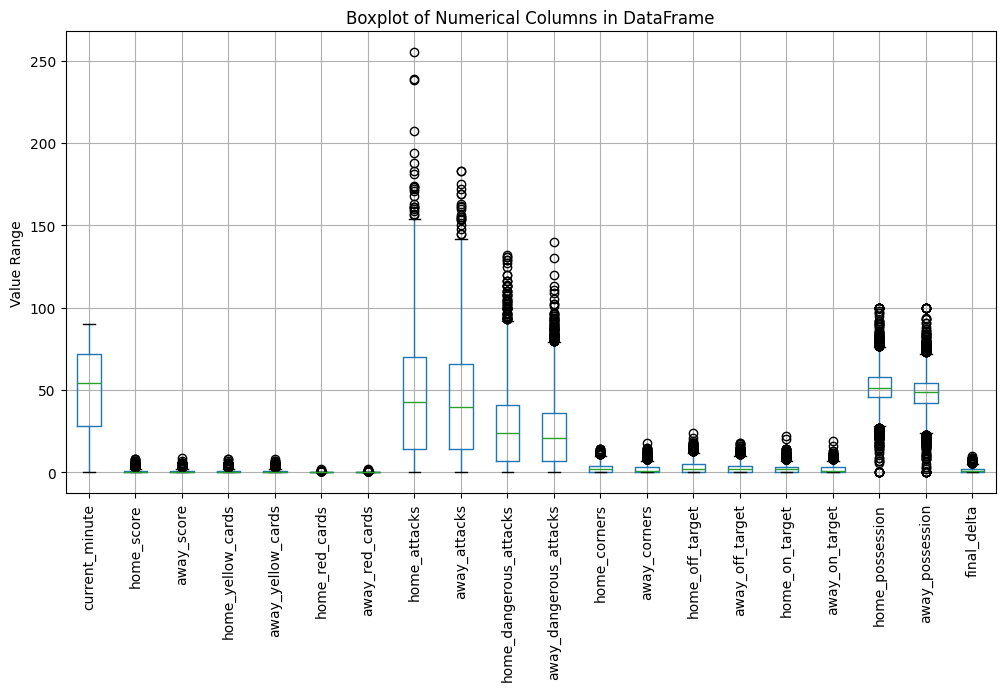

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/SportsTrading/match_snapshot_public_training - training.csv').drop(columns='uuid')

# A features DataFrame and a target DataFrame.
df_train_X = df_train.drop(columns='final_delta')
df_train_y = df_train['final_delta']

# A features list and a target list.
X = df_train_X.values
y = df_train_y.values

# Get feature and target names.
feature_columns = df_train.drop(columns='final_delta').columns
target_column = 'final_delta'

df = df_train

# Filter
df_no_anomalies = RemoveAnomalies(df, 'current_minute', 0, 105)
df_no_anomalies = RemoveAnomalies(df_no_anomalies, 'final_delta', 0, 100)

# Remove a half time.
df_no_anomalies.loc[df_no_anomalies['current_minute'] > 45, 'current_minute'] -= 15

# A features DataFrame and a target DataFrame.
df_X_no_anomalies = df_no_anomalies.drop(columns=['final_delta'])
df_y_no_anomalies = df_no_anomalies['final_delta']

# A features list and a target list.
X_no_anomalies = df_X_no_anomalies.values
y_no_anomalies = df_y_no_anomalies.values

columns_all = df_X_no_anomalies.columns

print(len(df_no_anomalies))

# Create a boxplot.
plt.figure(figsize=(12, 6))
df_no_anomalies.boxplot(rot=90)  # Rotate x-axis labels for readability
plt.title("Boxplot of Numerical Columns in DataFrame")
plt.ylabel("Value Range")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

models = {
            'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=11),
            'LogisticRegression': LogisticRegression(max_iter=2000),
            'LinearSVC': LinearSVC(),
            'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
            'RandomForestClassifier': RandomForestClassifier(random_state=42),
            'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42),
            'MLPClassifier': MLPClassifier(max_iter=5000, random_state=42)
        }

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scaler = MinMaxScaler()

# Calucurate train scores of a single model.（cross_val_score only calculate test scores.）
for model_name, model in models.items():
    print(f"=== {model_name} ===")

    # Execute cross-validation for original data.
    pipeline = make_pipeline(scaler, model)
    cv_result = cross_validate(pipeline, X_no_anomalies, y_no_anomalies, cv=kfold, return_train_score=True, return_indices=True, return_estimator=True)

    # Split train and test datasets according to Stratified K-Fold (SKF) rules.
    for fold_index, (train_score_for_single_fold, test_score_for_single_fold, fitted_estimator) in enumerate(zip(cv_result['train_score'], cv_result['test_score'], cv_result['estimator'])):
      # Output scores.
      print("test score: {:.3f}   ".format(test_score_for_single_fold), "train score: {:.3f}".format(train_score_for_single_fold))
    print("\n")

=== KNeighborsClassifier ===
test score: 0.370    train score: 0.477
test score: 0.351    train score: 0.473
test score: 0.358    train score: 0.468
test score: 0.348    train score: 0.471
test score: 0.343    train score: 0.467


=== LogisticRegression ===
test score: 0.370    train score: 0.380
test score: 0.373    train score: 0.377
test score: 0.369    train score: 0.378
test score: 0.361    train score: 0.379
test score: 0.379    train score: 0.377


=== LinearSVC ===
test score: 0.364    train score: 0.367
test score: 0.356    train score: 0.372
test score: 0.357    train score: 0.366
test score: 0.358    train score: 0.370
test score: 0.371    train score: 0.367


=== DecisionTreeClassifier ===
test score: 0.301    train score: 0.979
test score: 0.310    train score: 0.980
test score: 0.288    train score: 0.979
test score: 0.306    train score: 0.982
test score: 0.305    train score: 0.980


=== RandomForestClassifier ===
test score: 0.387    train score: 0.979
test score: 0.37

In [ ]:
# 異常値を除いた特長量および目的変数のみで分類予測.
# Logistic regression と Linear SVC の線形分類モデルのtrain score が低い⇒モデルが線形パターン（重み付き線形和で表現可能な分類境界）を発見できていない.
# Gradient Boosting は浅い決定木の為, train score が低くなっていると考えられる.
# MLPのtrain scoreはepoch, iteration, 学習方法がデフォルトでどうなっているか確認しないと説明できない.少なくともパターン認識はできていない.
# Random forest のスコアが最も高いため, このモデルからデータを読み解いていく.

In [ ]:
# Random forest (no_anomalies data)
rf = RandomForestClassifier(random_state=42)
pipeline = make_pipeline(scaler, rf)
cv_result = cross_validate(pipeline, X_no_anomalies, y_no_anomalies, cv=kfold, return_train_score=True, return_indices=True, return_estimator=True)

# Split train and test datasets according to Stratified K-Fold (SKF) rules.
for fold_index, (train_score_for_single_fold, test_score_for_single_fold, fitted_estimator) in enumerate(zip(cv_result['train_score'], cv_result['test_score'], cv_result['estimator'])):
  # Output scores.
  print("test score: {:.3f}   ".format(test_score_for_single_fold), "train score: {:.3f}".format(train_score_for_single_fold))
print("\n")
rf_grid_polynomial, _, y_no_anomalies_test = ProcessGridSearch(X=X_no_anomalies, y=y_no_anomalies, model=rf, feature_names=df_X_no_anomalies.columns, scaler=MinMaxScaler())

In [ ]:
# random forestが精度高かったので, 一旦採用.
# このモデルを基に精度向上を考えていく.
#次で, randomな予測成功率を考慮しなくてはならない．

In [ ]:
from collections import Counter

# 本物のデータのラベル分布
class_counts = Counter(y_no_anomalies_test)
total_samples = len(y_no_anomalies_test)

# 各クラスの出現確率を計算
class_probs = {cls: count / total_samples for cls, count in class_counts.items()}
# Output: {np.int64(1): 0.3034037558685446, np.int64(4): 0.05369718309859155, np.int64(2): 0.19923708920187794, np.int64(0): 0.301056338028169, np.int64(3): 0.10651408450704225, np.int64(5): 0.02171361502347418, np.int64(6): 0.009242957746478873, np.int64(9): 0.0008802816901408451, np.int64(8): 0.0010269953051643193, np.int64(7): 0.0030809859154929575, np.int64(10): 0.00014671361502347418}

# 事前確率に従ったランダム予測
y_pred_random = np.random.choice(list(class_probs.keys()), size=total_samples, p=list(class_probs.values()))

print(classification_report(y_no_anomalies_test, y_pred_random))

In [ ]:
# random forest の方がランダム予測よりも, 主要ラベルのf1スコアが大幅に伸びていることから,
# accuracy同士を比較して, およそ1.7割程度の予測の必然性向上が認められる．
# 目標は, 現段階で1.7割程度の予測必然性を向上させること．
# 新たに相互作用特徴量をドメイン知識を基に作成することで, 必然性の向上を目指す.

In [ ]:
# Create features per minute dataframe.
df_permin = df_no_anomalies.copy()

# features per minute array.
per_minute_features = [
		'home_score',
		'away_score',
		'home_yellow_cards',
		'away_yellow_cards',
		'home_red_cards',
		'away_red_cards',
		'home_attacks',
		'away_attacks',
		'home_dangerous_attacks',
		'away_dangerous_attacks',
		'home_corners',
		'away_corners',
		'home_off_target',
		'away_off_target',
		'home_on_target',
		'away_on_target'
	]

df_permin['current_minute'] = df_permin['current_minute'].replace(0, 1)  # Replace zero minutes with 1 to prevent division by zero

# Create per minute columns.
for feature in per_minute_features:
	new_feature = f"{feature}_per_minute"
	df_permin[new_feature] = df_permin[feature] / df_permin['current_minute']

# Drop columns.
df_permin = df_permin.drop(columns=per_minute_features)

# Move the target column to the last position.
col_data = df_permin.pop('final_delta')
df_permin['final_delta'] = col_data

# Split the dataframe into features and target
df_X_permin = df_permin.copy().drop(columns='final_delta')
df_y_permin = df_permin['final_delta']

# Convert to NumPy arrays
X_permin = df_X_permin.values
y_permin = df_y_permin.values

# Random forest (per_min data)
rf = RandomForestClassifier(random_state=42)
pipeline = make_pipeline(scaler, rf)
cv_result = cross_validate(pipeline, X_permin, y_permin, cv=kfold, return_train_score=True, return_indices=True, return_estimator=True)

# Split train and test datasets according to Stratified K-Fold (SKF) rules.
for fold_index, (train_score_for_single_fold, test_score_for_single_fold, fitted_estimator) in enumerate(zip(cv_result['train_score'], cv_result['test_score'], cv_result['estimator'])):
	# Output scores.
	print("test score: {:.3f}   ".format(test_score_for_single_fold), "train score: {:.3f}".format(train_score_for_single_fold))
print("\n")
rf_grid_polynomial, _, y_no_anomalies_test = ProcessGridSearch(X=X_permin, y=y_permin, model=rf, feature_names=df_permin.columns, scaler=MinMaxScaler())

test score: 0.383    train score: 0.979
test score: 0.390    train score: 0.980
test score: 0.360    train score: 0.979
test score: 0.357    train score: 0.982
test score: 0.399    train score: 0.979




In [ ]:
df_ratio = df_no_anomalies.copy()

df_ratio['home_shot_accuracy'] = df_ratio['home_on_target'] / (df_ratio['home_on_target'] + df_ratio['home_off_target']).replace(0, 1)
df_ratio['away_shot_accuracy'] = df_ratio['away_on_target'] / (df_ratio['away_on_target'] + df_ratio['away_off_target']).replace(0, 1)

df_ratio['home_dangerous_attack'] = df_ratio['home_dangerous_attacks'] / (df_ratio['home_attacks']).replace(0, 1)
df_ratio['away_dangerous_attack'] = df_ratio['away_dangerous_attacks'] / (df_ratio['away_attacks']).replace(0, 1)

df_ratio['home_dangerous_to_goal'] = df_ratio['home_score'] / (df_ratio['home_dangerous_attacks']).replace(0, 1)
df_ratio['away_dangerous_to_goal'] = df_ratio['away_score'] / (df_ratio['away_dangerous_attacks']).replace(0, 1)

# Create features ratio array.
ratio_features = {
		'home_yellow_cards': 'away_yellow_cards',
		'home_red_cards': 'away_red_cards',
		'home_attacks': 'away_attacks',
		'home_dangerous_attacks': 'away_dangerous_attacks',
		'home_corners': 'away_corners',
		'home_off_target': 'away_off_target',
		'home_on_target': 'away_on_target',
		'home_possession': 'away_possession',
		'home_shot_accuracy': 'away_shot_accuracy',
		'home_dangerous_attack': 'away_dangerous_attack',
		'home_dangerous_to_goal': 'away_dangerous_to_goal'
	}

# Convert keys (home features) and values (away features) to NumPy arrays
home_features_array = np.array(list(ratio_features.keys()))
away_features_array = np.array(list(ratio_features.values()))
# Concatenate along rows to form a single 1D array
combined_array = np.concatenate((home_features_array, away_features_array))

# Avoid division by zero by replacing zeros with small values (e.g., 1e-6)
for home_feature, away_feature in ratio_features.items():
	new_feature = f"{home_feature.replace('home_', '')}_ratio"
	df_ratio[away_feature] = df_ratio[away_feature].replace(0, 1)  # Prevent division by zero
	df_ratio[new_feature] = df_ratio[home_feature] / df_ratio[away_feature]

# Drop columns.
df_ratio = df_ratio.drop(columns=combined_array)

# Move the target column to the last position.
col_data = df_ratio.pop('final_delta')
df_ratio['final_delta'] = col_data

# Split the dataframe into features and target
df_X_ratio = df_ratio.copy().drop(columns='final_delta')
df_y_ratio = df_ratio['final_delta']

# Convert to NumPy arrays
X_ratio = df_X_ratio.values
y_ratio = df_y_ratio.values

# Random forest (ratio data)
rf = RandomForestClassifier(random_state=42)
pipeline = make_pipeline(scaler, rf)
cv_result = cross_validate(pipeline, X_ratio, y_ratio, cv=kfold, return_train_score=True, return_indices=True, return_estimator=True)

# Split train and test datasets according to Stratified K-Fold (SKF) rules.
for fold_index, (train_score_for_single_fold, test_score_for_single_fold, fitted_estimator) in enumerate(zip(cv_result['train_score'], cv_result['test_score'], cv_result['estimator'])):
	# Output scores.
	print("test score: {:.3f}   ".format(test_score_for_single_fold), "train score: {:.3f}".format(train_score_for_single_fold))
print("\n")
rf_grid_polynomial, _, y_no_anomalies_test = ProcessGridSearch(X=X_ratio, y=y_ratio, model=rf, feature_names=df_ratio.columns, scaler=MinMaxScaler())

test score: 0.386    train score: 0.977
test score: 0.382    train score: 0.979
test score: 0.337    train score: 0.977
test score: 0.360    train score: 0.981
test score: 0.386    train score: 0.979




In [ ]:
df_merged_all = pd.concat([df_X_no_anomalies, df_X_permin, df_ratio], axis=1)  # 横に結合
df_merged_all = df_merged_all.loc[:, ~df_merged_all.columns.duplicated()].drop(columns=['away_red_cards_per_minute',
                                                                                        'away_red_cards',
                                                                                        'home_red_cards_per_minute',
                                                                                        # 'home_red_cards',
                                                                                        ]) # 重複カラムの削除, ~:bool反転, 特長量重要度が低いカラムを削除.

# Split the dataframe into features and target
df_X_merged_all = df_merged_all.copy().drop(columns=['final_delta'])
df_y_merged_all = df_merged_all['final_delta']

# Convert to NumPy arrays
X_merged_all = df_X_merged_all.values
y_merged_all = df_y_merged_all.values

# Random forest (polynomial data)
rf = RandomForestClassifier(random_state=42)
pipeline = make_pipeline(scaler, rf)
cv_result = cross_validate(pipeline, X_merged_all, y_merged_all, cv=kfold, return_train_score=True, return_indices=True, return_estimator=True)

for fold_index, (train_score_for_single_fold, test_score_for_single_fold, fitted_estimator) in enumerate(zip(cv_result['train_score'], cv_result['test_score'], cv_result['estimator'])):
	# Output scores.
	print("test score: {:.3f}   ".format(test_score_for_single_fold), "train score: {:.3f}".format(train_score_for_single_fold))
print("\n")
rf_grid_polynomial, _, y_polynomial_test = ProcessGridSearch(X=X_polynomial, y=y_polynomial, model=rf, feature_names=df_X_polynomial.columns, scaler=MinMaxScaler())

test score: 0.401    train score: 0.979
test score: 0.395    train score: 0.980
test score: 0.368    train score: 0.979
test score: 0.371    train score: 0.982
test score: 0.389    train score: 0.980




In [ ]:
df_merged_portion = pd.concat([df_X_permin, df_ratio], axis=1)
df_merged_portion = df_merged_portion.loc[:, ~df_merged_portion.columns.duplicated()].drop(columns=['away_red_cards_per_minute',
                                                                                                    'home_red_cards_per_minute',
                                                                                                    'red_cards_ratio'
                                                                                                    ]) # 重複カラムの削除, ~:bool反転, 特長量重要度が低いカラムを削除.

# Split the dataframe into features and target
df_X_merged_portion = df_merged_portion.copy().drop(columns=['final_delta'])
df_y_merged_portion = df_merged_portion['final_delta']

# Convert to NumPy arrays
X_merged_portion = df_X_merged_portion.values
y_merged_portion = df_y_merged_portion.values

# Random forest (polynomial data)
rf = RandomForestClassifier(random_state=42)
pipeline = make_pipeline(scaler, rf)
cv_result = cross_validate(pipeline, X_merged_portion, y_merged_portion, cv=kfold, return_train_score=True, return_indices=True, return_estimator=True)

for fold_index, (train_score_for_single_fold, test_score_for_single_fold, fitted_estimator) in enumerate(zip(cv_result['train_score'], cv_result['test_score'], cv_result['estimator'])):
	# Output scores.
	print("test score: {:.3f}   ".format(test_score_for_single_fold), "train score: {:.3f}".format(train_score_for_single_fold))
print("\n")
rf_grid_polynomial, _, y_no_anomalies_test = ProcessGridSearch(X=X_poly_2, y=y_poly_2, model=rf, feature_names=df_merged_portion.columns, scaler=MinMaxScaler())

test score: 0.391    train score: 0.979
test score: 0.387    train score: 0.980
test score: 0.372    train score: 0.979
test score: 0.376    train score: 0.982
test score: 0.381    train score: 0.979




In [ ]:
# accuracyとf1_score の weighted avg が最も高いdf_ratioを採用
# 相互作用特徴量に意味があるのかを確認する為, shapを使用する.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_ratio, y_ratio, test_size=0.2, random_state=42)

# モデルの学習
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# SHAP値の計算
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [ ]:
np.shape(shap_values) # Output(i, j, k) i番目のサンプルの, j番目の特長量が, k番目のクラス予測に与える影響.

# ゲーム理論のshapley値の例に言い換えると
# i回目の試合で, jさんが, 結果項目kに対してどれだけ貢献したか⇒shapley値

In [ ]:
# クラス0分類における, 目的変数への寄与度(SHPA値の絶対値)
df_y_train = pd.DataFrame(y_train, columns=[df_y_ratio.name])
df_X_test = pd.DataFrame(X_test, columns=df_X_ratio.columns)

for i in np.unique(df_y_train):
    fig, ax = plt.subplots(figsize=(10, 6))  # figsizeを適切な値に調整
    plt.title(f"Cluster {i}")

    # SHAPプロット
    shap.summary_plot(shap_values[:, :, i], df_X_test, plot_type="bar", max_display=10, show=False)

    # レイアウト調整
    plt.tight_layout()
    plt.show()

In [ ]:
# いずれのクラスタでも current_minute が最上位
# rawデータでは, 一見重要そうなattacks類も実はcurrent_minuteとの相関が強い.
# 他の特徴量がcurrent_minute に対して独立性が高くなっている為, current_minute以外のshapley値が極端に小さくなっている.
# 主要クラス0, 1, 2 のTOP5特徴量とcurrent_minuteとの相関を以下で確認.

In [ ]:
best_shap_columns = ['current_minute', 'corners_ratio', 'dangerous_attack_ratio', 'attacks_ratio', 'off_target_ratio', 'yellow_cards_ratio']

df_best_shap = df_X_ratio[best_shap_columns]

# 共分散行列の計算
corr_matrix = df_best_shap.corr()

# ヒートマップの描画
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")

plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# dangerous_attack_ratio と off_target_ratio は, 経過時間が大きくなるに連れてゴール回りのシュートが増加する為, 比較的相関あり. そのほかの特徴量は予想通りcurrent_minuteからの独立性が強い.
# とにかく, これまで提案してきた特徴量を使っても, current_minuteでしか分類できない事が分かった.

# なぜcurrent_minuteがfinal_deltaに大きく影響するのか.
# ※time_rateでさえshap値は0.07と非常に低いことを忘れない！

In [ ]:
# 前半と後半のfinal_deltaの最小値と最大値を取得
final_delta_min = df_ratio["final_delta"].min()
final_delta_max = df_ratio["final_delta"].max()

# 共通のビン範囲を設定
bins = range(final_delta_min, final_delta_max + 1)

# ヒストグラムの描画（共通のビンを使用）
plt.figure(figsize=(12, 6))
sns.histplot(df_ratio[df_ratio["current_minute"] < 45]["final_delta"], bins=bins, kde=True, label="First Half (0-44 min)", color="blue", alpha=0.5)
sns.histplot(df_ratio[df_ratio["current_minute"] >= 45]["final_delta"], bins=bins, kde=True, label="Second Half (45+ min)", color="red", alpha=0.5)
plt.xlabel("Final Delta")
plt.ylabel("Frequency")
plt.title("Distribution of Final Delta in First and Second Half")
plt.legend()
plt.grid(True)
plt.show()

# 共通のビン範囲を設定
bins = range(final_delta_min, final_delta_max + 1)

# ヒストグラムの描画（15分ごとのヒストグラムを作成）
plt.figure(figsize=(12, 6))
time_intervals = [(0, 15), (15, 30), (30, 45), (45, 60), (60, 75), (75, 90)]
colors = ["blue", "green", "purple", "red", "orange", "brown"]

for (start, end), color in zip(time_intervals, colors):
    sns.histplot(
        df_ratio[(df_ratio["current_minute"] >= start) & (df_ratio["current_minute"] < end)]["final_delta"],
        bins=bins, kde=True, label=f"{start}-{end} min", color=color, alpha=0.7
    )

    plt.xlabel("Final Delta")
    plt.ylabel("Frequency")
    plt.title("Distribution of Final Delta in 15-Minute Intervals")
    plt.legend()
    plt.grid(True)
    plt.show()

# 各 current_minute における final_delta の標準偏差を計算
std_by_minute = df_ratio.groupby("current_minute")["final_delta"].std()

# 標準偏差のプロット
plt.figure(figsize=(10, 5))
plt.plot(std_by_minute.index, std_by_minute.values, marker="o", linestyle="-", alpha=0.8)
plt.xlabel("Current Minute")
plt.ylabel("Standard Deviation of Final Delta")
plt.title("Final Delta Standard Deviation Over Time")
plt.grid(True)
plt.show()

# 5分おきのデータ量を可視化.
plt.figure(figsize=(10, 5))
sns.histplot(df_ratio[df_ratio["current_minute"].between(0, 90)]["current_minute"], bins=19, kde=False, color="red", alpha=0.7)
plt.xlabel("Current Minute (0-90 min)")
plt.ylabel("Frequency")
plt.title("Histogram of Data Count (0-90 min)")
plt.grid(True)
plt.show()

In [ ]:
# 撮影時間のインターバルによるfinal_delta分布が変化している.
# final_deltaが "残り時間内にhomeとaway両方から生まれる合計得点数" であるとすれば説明が付く.

# 点群の広がりを可視化してから, 第一検討として完了しよう.
# まず, 重心と点群の広がりでクラスタの被覆を検証する.

In [ ]:
def compute_distance_matrix(df: pd.DataFrame) -> pd.DataFrame:
	"""
	df の各カラムを1つのベクトル (df.shape[0]次元) とみなし、
	すべてのカラムペア(i, j)間のユークリッド距離を計算して
	DataFrame (距離行列) として返す。

	Parameters:
	-----------
	df : pd.DataFrame
		距離を計算したいデータが入ったDataFrame

	Returns:
	--------
	dist_df : pd.DataFrame
		カラム名を行・列インデックスに持ち、要素がユークリッド距離の距離行列
	"""
	columns = df.columns
	m = len(columns)

	# 結果格納用のDataFrameを作成（行列サイズ：m×m）
	dist_df = pd.DataFrame(np.zeros((m, m)), index=columns, columns=columns)

	# DataFrameをnumpy配列に変換: shape (n, m)
	#   - n = 行数（サンプル数）
	#   - m = カラム数（特徴量数）
	values = df.values

	# 各カラムを順にベクトルとして取り出し、距離を計算
	for i in range(m):
		vec_i = values[:, i]
		for j in range(m):
			vec_j = values[:, j]
			# ユークリッド距離を計算
			# dist(i, j) = sqrt( Σ_k (vec_i[k] - vec_j[k])^2 )
			dist_ij = np.linalg.norm(vec_i - vec_j)
			dist_df.iloc[i, j] = dist_ij

	return dist_df

# 適宜変更：前処理済みのDataFrame。featuresと'target'列(ここでは'final_delta')が含まれている前提
X_scaled = scaler.fit_transform(df_X_ratio)
y_scaled = df_y_ratio.copy()

# DataFrameに再構築
df_scaled = pd.DataFrame(X_scaled, columns=df_X_ratio.columns)
df_scaled['final_delta'] = y_scaled

colors = ['blue','red','green','orange','purple','brown','pink','gray','olive','cyan', 'yellow']
unique_deltas = np.unique(df_ratio['final_delta'])

# 重心(centroid)を格納する辞書と、全距離を集約するリスト
centroids = {}
all_norms = []

# 重心と全距離を一度に算出
for fd in unique_deltas:
	df_fd = df_scaled[df_scaled['final_delta'] == fd].drop('final_delta', axis=1)
	centroids[fd] = df_fd.mean().values  # 列方向に平均をとり重心ベクトルを生成
	all_norms += [np.linalg.norm(x - centroids[fd]) for x in df_fd.values]

df_centroid = pd.DataFrame(centroids)

# 全ラベル共通のビンを作成
bins = np.histogram_bin_edges(all_norms, bins=100)

plt.figure(figsize=(10,6))
for i, fd in enumerate(unique_deltas):
	df_fd = df_scaled[df_scaled['final_delta'] == fd].drop('final_delta', axis=1)
	# 距離計算
	norms = [np.linalg.norm(x - centroids[fd]) for x in df_fd.values]
	avg_dist = np.mean(norms)
	color = colors[i % len(colors)]

	# ヒストグラム＆平均線
	plt.hist(norms, bins=bins, alpha=0.5, color=color, label=f'final_delta {int(fd)}')
	plt.axvline(avg_dist, color=color, linestyle='--', label=f'Mean {int(fd)}')
	print(f"[label {fd}] average_distance: {avg_dist:.3f}")

print('-'*50)

final_delta_counts = df_scaled['final_delta'].value_counts()
print(final_delta_counts)

plt.title('Distance Histogram for final_delta')
plt.xlabel('Distance from centroid')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

distance_matrix = compute_distance_matrix(df_centroid)

# Create a heatmap.
plt.figure(figsize=(10, 10))
sns.heatmap(distance_matrix,
			annot=True,     # 各セルに数値を表示
			fmt=".2f",
			cmap="viridis")
plt.title("Distance Matrix Heatmap")
plt.show()

# 超球面と仮定. ⇒形状を無視.

In [ ]:
# クラスタ0を基準に見ると, labelが大きくなるにつれて, 重心間距離が離れていく傾向がある.
# 重心から, 半径avg_distanceとした超球面を仮定すると, 主要クラスタ同士の被覆が大きく, そのほかは部分的な被覆が見られる.
# 超球面であると仮定しているが、クラスタ同士が内包する関係にあることから、クラスタの形状に依らずクラスタリング不可.

In [ ]:
# 分散の大きい方向から点群を観察する.

In [ ]:
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt

def plot_dimensionality_reduction_results(X_transformed: np.ndarray, y: np.ndarray, model, feature_columns: list[str], method_name: str = "PCA") -> None:
    """
    Plot dimensionality reduction results (scatter plot and component heatmap).

    Args:
        X_transformed (np.ndarray): Transformed data (e.g., PCA or NMF output).
        y (np.ndarray): Target labels as a 1D numpy array.
        model: A fitted dimensionality reduction model (e.g., PCA or NMF).
        feature_columns (list): List of feature column names.
        method_name (str): Name of the dimensionality reduction method ("PCA" or "NMF").
    """

    n_components = X_transformed.shape[1]
    unique_labels = np.unique(y)

    # マーカーの候補をリストに定義
    markers = ["o", "s", "^", "v", "*", "x", "D", "P"]

    # 散布図 (2次元ずつプロット)
    for i in range(n_components - 1):
        plt.figure(figsize=(8, 8))
        for idx, label in enumerate(unique_labels):
            # マーカーをラベルごとに切り替え（ラベル数が多いときはループ）
            marker = markers[idx % len(markers)]
            plt.scatter(
                X_transformed[y == label, i],
                X_transformed[y == label, i + 1],
                label=label,
                alpha=0.7,
                marker=marker
            )
        plt.legend(loc="best")
        plt.gca().set_aspect("equal", adjustable="datalim")
        plt.xlabel(f"{method_name} Component {i+1}")
        plt.ylabel(f"{method_name} Component {i+2}")
        plt.title(f"{method_name} Scatter Plot: Component {i+1} vs Component {i+2}")
        plt.show()

    # コンポーネント行列のヒートマップ
    plt.figure(figsize=(10, 5))
    plt.matshow(model.components_, cmap='viridis')
    plt.yticks(
        range(model.components_.shape[0]),
        [f"{method_name} Component {i+1}" for i in range(model.components_.shape[0])]
    )
    plt.colorbar()
    plt.xticks(range(len(feature_columns)), feature_columns, rotation=90, ha='right')
    plt.xlabel("Feature")
    plt.ylabel(f"{method_name} Components")
    plt.title(f"{method_name} Component Heatmap")
    plt.show()


def PlotPCA(X, y, feature_columns, n_components: int, scaler) -> tuple[pd.DataFrame, pd.DataFrame, PCA]:
        """Show scatter plot of PCA scaled data and plot explained_variance_ratio.

        Args:
            n_components (int): Determine the number of dimensions as a parameter of PCA.

        Returns:
            X_scaled (pandas.core.frame.DataFrame): Dataframe of scaled data.
            df_pca (pandas.core.frame.DataFrame): Dataframe after dimensionality reduction with PCA.
            pca (sklearn.decomposition._pca.PCA): A fitted PCA model that contains attributes to explain the results.
        """

        # Fit a scaler to X and transform.
        X_scaled = scaler.fit_transform(X)

        # Initialize a PCA.
        pca = PCA(n_components=n_components, random_state=0)

        # Fit PCA to X_scaled data and transform using components extracted by PCA.
        X_pca = pca.fit_transform(X_scaled)

        # Create a dataframe for scaled data.
        df_X_scaled = pd.DataFrame(X_scaled, columns=feature_columns)

        # Create a dataframe for PCA-reduced data.
        df_pca = pd.DataFrame(X_pca)

        # 既存の散布図等を描画するメソッドを呼び出し
        plot_dimensionality_reduction_results(X_pca, y, pca, feature_columns, "PCA")

        # --- ここから下が PCA の結果可視化（累積寄与率など）を追加した部分 ---

        # 寄与率（各主成分がデータの分散をどの程度説明しているか）
        explained_variance_ratio = pca.explained_variance_ratio_
        # 累積寄与率
        cumulative_explained_variance = np.cumsum(explained_variance_ratio)

        # グラフ描画
        plt.figure(figsize=(8, 4))

        # 各主成分の寄与率を棒グラフで表示
        plt.bar(
            range(1, len(explained_variance_ratio) + 1),
            explained_variance_ratio,
            alpha=0.5,
            align='center',
            label='Individual explained variance'
        )

        # 累積寄与率をステッププロット（または折れ線）で重ねる
        plt.step(
            range(1, len(cumulative_explained_variance) + 1),
            cumulative_explained_variance,
            where='mid',
            label='Cumulative explained variance'
        )

        plt.xlabel('Principal Component')
        plt.ylabel('Explained Variance Ratio')
        plt.title('PCA Explained Variance')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()
        # --- 追加部分はここまで ---

        return df_X_scaled, df_pca, pca

df_X_scaled, df_pca, pca = PlotPCA(X_ratio, y_ratio, df_X_ratio.columns, n_components=5, scaler=scaler)

In [ ]:
# PCAで分散の大きい方向を可視化.
# 第一主成分で点群を見ると, 大きいクラスタが小さいクラスタを内包している. current_minuteが構成の大半を占める.
# 第二主成分以降も分離されていないことから, クラスタは主要ラベルがその他ラベルを内包していると考えられる.
# 主要ラベルがほぼ被覆⇒クラスタリング不可.

# 残された道
# 1. 有効な相互作用特徴量の探索⇒ドメイン知識の限界により, 不可.
# 2. モデルの変更⇒クラスタの分離ができていない為, 精度の向上は期待できない.
# 3. 線形回帰タスクに移行.⇒〇

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, PoissonRegressor

# Define models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=0.1, max_iter=5000),
    "Lasso": Lasso(alpha=0.1, max_iter=5000),
    "PoissonRegressor": PoissonRegressor(alpha=0.1, max_iter=5000)
}

# Define cross-validation strategy and scaler
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scaler = StandardScaler()

def ProcessRegressionModels(X, y, dataset_name, kfold, scaler, models):
    results = {}  # Initialize results dictionary
    trained_models = {}

    for model_name, model in models.items():

        # Create pipeline with scaling and model
        pipeline = make_pipeline(scaler, model)

        # Perform cross-validation
        cv_result = cross_validate(
            pipeline, X, y,
            cv=kfold,
            scoring=['neg_mean_squared_error', 'r2'],
            return_train_score=True
        )

        trained_models[model_name] = pipeline  # Store trained model

        # Extract scores
        train_mse_scores = -cv_result['train_neg_mean_squared_error']  # Convert negative MSE to positive
        test_mse_scores = -cv_result['test_neg_mean_squared_error']
        train_r2_scores = cv_result['train_r2']
        test_r2_scores = cv_result['test_r2']

        # Compute RMSE
        train_rmse_scores = np.sqrt(train_mse_scores)
        test_rmse_scores = np.sqrt(test_mse_scores)

        # Compute mean scores
        mean_train_r2 = np.mean(train_r2_scores)
        mean_train_rmse = np.mean(train_rmse_scores)
        mean_test_r2 = np.mean(test_r2_scores)
        mean_test_rmse = np.mean(test_rmse_scores)

        # Store results in dictionary with rounded values
        results[model_name] = [
            round(mean_train_r2, 3),
            round(mean_train_rmse, 3),
            round(mean_test_r2, 3),
            round(mean_test_rmse, 3)
        ]

    # Create DataFrame from results
    index = ["Mean Train R²", "Mean Train RMSE", "Mean Test R²", "Mean Test RMSE"]
    df_results = pd.DataFrame(results, index=index)

    return df_results, trained_models

# Execute regression models for multiple datasets
datasets = [
    ("No Anomalies", X_no_anomalies, y_no_anomalies),
    ("Permin", X_permin, y_permin),
    ("Ratio", X_ratio, y_ratio),
    ("Merged Portion", X_merged_portion, y_merged_portion),
    ("Merged All", X_merged_all, y_merged_all)
]

for dataset_name, X, y in datasets:
    df_results, trained_models = ProcessRegressionModels(X, y, dataset_name, kfold, scaler, models)

    print(f"Results for {dataset_name}:")
    print(df_results)
    print('-'*75)

Results for No Anomalies:
                 LinearRegression  Ridge  Lasso  PoissonRegressor
Mean Train R²               0.263  0.263  0.253             0.252
Mean Train RMSE             1.221  1.221  1.230             1.231
Mean Test R²                0.259  0.259  0.252             0.247
Mean Test RMSE              1.225  1.225  1.230             1.234
---------------------------------------------------------------------------
Results for Permin:
                 LinearRegression  Ridge  Lasso  PoissonRegressor
Mean Train R²               0.266  0.266  0.253             0.254
Mean Train RMSE             1.219  1.219  1.230             1.229
Mean Test R²                0.260  0.260  0.252             0.247
Mean Test RMSE              1.224  1.224  1.230             1.235
---------------------------------------------------------------------------
Results for Ratio:
                 LinearRegression  Ridge  Lasso  PoissonRegressor
Mean Train R²               0.263  0.263  0.253          

In [ ]:
# df_merged_portion のLinier Regression と Ridge が最も高い精度が出た (ドングリの背比べ程度)
# 特徴量が正規分布にしたがっていると, 残差も正規分布に従いやすいため, StandardScalerを用いた.
# final_delta のサンプル量がポアソン分布に従うのに, Poisson Regressor のスコアが低い.

# Poisson 回帰の前提
# 予測された確率変数 Y がポアソン分布に従う. 且つカウントデータ

# 実際のデータセットとの相性を確認する.
# 1. カウントデータか (Yes. 2へ)
# 2. 目的変数はポアソン分布の見た目か (Yesなら3へ)

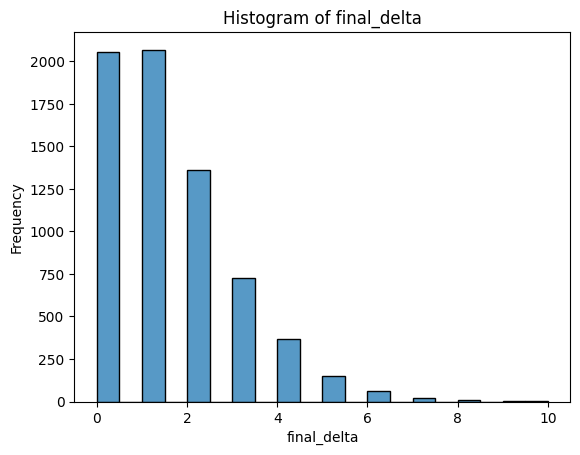

In [ ]:
sns.histplot(df_merged_portion['final_delta'], bins=20)
plt.xlabel('final_delta')
plt.ylabel('Frequency')
plt.title('Histogram of final_delta')
plt.show()

In [ ]:
# その前に...
# Poisson Regressorで計算されたPoisson分布の平均値λを可視化.

Training R^2 Score: 0.243
Training RMSE: 1.223
Test R^2 Score: 0.239
Test RMSE: 1.244




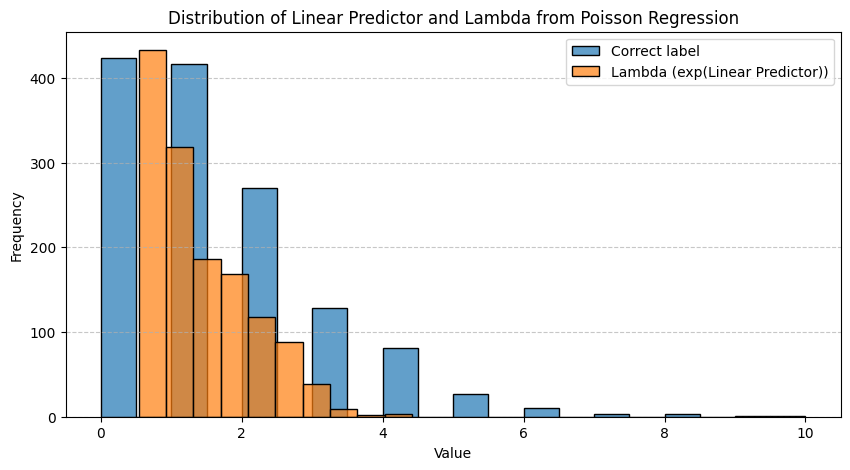

In [ ]:
# データの分割
X_train, X_test, y_train, y_test = train_test_split(df_X_merged_portion, df_y_merged_portion, test_size=0.2, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Poisson回帰モデルの訓練と格納
poisson_model = PoissonRegressor(alpha=0.1, max_iter=2000)
poisson_model.fit(X_train_scaled, y_train)

# モデルのスコア計算
r2_train = poisson_model.score(X_train_scaled, y_train)
r2_test = poisson_model.score(X_test_scaled, y_test)

# RMSE（Root Mean Squared Error）の計算
rmse_train = np.sqrt(mean_squared_error(y_train, poisson_model.predict(X_train_scaled)))
rmse_test = np.sqrt(mean_squared_error(y_test, poisson_model.predict(X_test_scaled)))

# 結果の表示
print(f"Training R^2 Score: {r2_train:.3f}")
print(f"Training RMSE: {rmse_train:.3f}")
print(f"Test R^2 Score: {r2_test:.3f}")
print(f"Test RMSE: {rmse_test:.3f}")
print('\n')

# 重み（係数）とバイアス（切片）の取得
weights = poisson_model.coef_
bias = poisson_model.intercept_

# 重み付き線形和（線形予測子）の計算
linear_combination = np.dot(X_test_scaled, weights) + bias

df_linear_combination = pd.DataFrame(linear_combination, columns=['linear_combination'])

# λ（Poisson分布の平均）を計算
ave = np.exp(linear_combination)

# dfへ格納
df_ave = pd.DataFrame(ave, columns=['lambda'])

# 線形予測子とλのヒストグラムを描画
plt.figure(figsize=(10, 5))

# final_delta のヒストグラム
sns.histplot(y_test, bins=20, edgecolor='black', alpha=0.7, label='Correct label')

# Lambda (exp(Linear Predictor)) のヒストグラム
sns.histplot(df_ave['lambda'], bins=10, edgecolor='black', alpha=0.7, label='Lambda (exp(Linear Predictor))')

# ラベルとタイトルの設定
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribution of Linear Predictor and Lambda from Poisson Regression")

# 凡例の表示
plt.legend()

# グリッドの設定
plt.grid(axis='y', linestyle='--', alpha=0.7)

# プロットの表示
plt.show()

In [ ]:
print(f'y_test shape: {y_test.shape}')
print(f"y_pred shape: {df_ave['lambda'].values.shape}")

y_test shape: (1364,)
y_pred shape: (1364,)


In [ ]:
# 予測の方がrangeが狭い.
# 重み付き線形和の取り得る値の幅が, 実データよりも狭い.
# この幅を引きはがすために何をすればよいか分からない.

# Poisson Regressorと同様に, Ridgeの予測分布を見てみる.

Training R^2 Score: 0.269
Training RMSE: 1.215
Test R^2 Score: 0.258
Test RMSE: 1.231



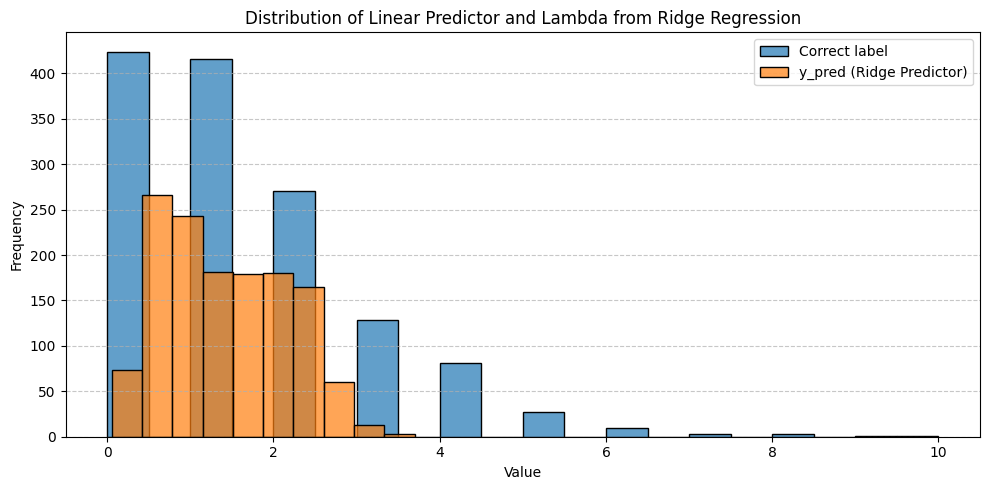

In [ ]:
# Ridge回帰モデルの定義と学習
ridge = Ridge(alpha=0.1)
ridge.fit(X_train_scaled, y_train)

# 予測
y_pred = ridge.predict(X_test_scaled)

# モデルのスコア計算
r2_train = ridge.score(X_train_scaled, y_train)
r2_test = ridge.score(X_test_scaled, y_test)

# RMSE（Root Mean Squared Error）の計算
rmse_train = np.sqrt(mean_squared_error(y_train, ridge.predict(X_train_scaled)))
rmse_test = np.sqrt(mean_squared_error(y_test, ridge.predict(X_test_scaled)))

# 結果の表示
print(f"Training R^2 Score: {r2_train:.3f}")
print(f"Training RMSE: {rmse_train:.3f}")
print(f"Test R^2 Score: {r2_test:.3f}")
print(f"Test RMSE: {rmse_test:.3f}\n")

# 重みとバイアスの取得
weights = ridge.coef_
bias = ridge.intercept_

# 予測値を DataFrame に変換
df_y_pred = pd.DataFrame(y_pred, columns=['y_pred'])

# binの幅を統一するため、共通の範囲を設定
min_value = 0
max_value = 10

# ヒストグラムの描画
plt.figure(figsize=(10, 5))

# final_delta のヒストグラム（正解ラベル）
sns.histplot(y_test, bins=20, edgecolor='black', alpha=0.7, label='Correct label')

# Lambda (exp(Linear Predictor)) のヒストグラム（予測値）
sns.histplot(df_y_pred['y_pred'], bins=10, edgecolor='black', alpha=0.7, label='y_pred (Ridge Predictor)')

# ラベルとタイトルの設定
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribution of Linear Predictor and Lambda from Ridge Regression")

# 凡例の表示
plt.legend()

# グリッドの設定
plt.grid(axis='y', linestyle='--', alpha=0.7)

# レイアウト調整
plt.tight_layout()

# プロットの表示
plt.show()

In [ ]:
# Ridgeの方が分布の範囲が広く, 予測値の極端な偏りが軽減.

# いずれにせよ, 正解ラベルの方が分布の分散が大きいことが分かった.
# 分散を確かめる.

In [ ]:
df_merged_portion.describe()

,current_minute,home_possession,away_possession,home_score_per_minute,away_score_per_minute,home_yellow_cards_per_minute,away_yellow_cards_per_minute,home_attacks_per_minute,away_attacks_per_minute,home_dangerous_attacks_per_minute,away_dangerous_attacks_per_minute,home_corners_per_minute,away_corners_per_minute,home_off_target_per_minute,away_off_target_per_minute,home_on_target_per_minute,away_on_target_per_minute,home_score,away_score,yellow_cards_ratio,attacks_ratio,dangerous_attacks_ratio,corners_ratio,off_target_ratio,on_target_ratio,possession_ratio,shot_accuracy_ratio,dangerous_attack_ratio,dangerous_to_goal_ratio,final_delta
count,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000
mean,49.337881,51.593163,48.403756,0.015525,0.012258,0.011401,0.013370,0.948251,0.884329,0.548377,0.483050,0.045917,0.038527,0.058360,0.048807,0.041594,0.034331,0.779783,0.607688,0.370852,1.278659,1.377396,1.316587,1.331551,1.218552,1.341397,0.756758,1.033860,0.381289,1.439407
std,26.095105,10.489913,10.491662,0.028549,0.024732,0.054097,0.089564,0.609840,0.540717,0.371032,0.336498,0.053155,0.054047,0.066232,0.052747,0.050050,0.044686,1.062014,0.907211,0.689143,4.403818,2.848791,1.738559,1.760631,1.556023,3.922935,0.912582,0.802495,1.339494,1.422953
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,46.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.625000,0.588002,0.326825,0.277778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.755006,0.632385,0.000000,0.000000,0.000000,0.851852,0.000000,0.698983,0.000000,0.000000
50%,54.000000,51.000000,49.000000,0.000000,0.000000,0.000000,0.000000,0.960912,0.901639,0.529412,0.457143,0.036475,0.028571,0.050000,0.039474,0.032787,0.025641,0.000000,0.000000,0.000000,1.000000,1.022222,0.866071,1.000000,1.000000,1.040816,0.533333,0.996069,0.000000,1.000000
75%,72.000000,58.000000,54.000000,0.023810,0.017544,0.014286,0.016129,1.263406,1.187500,0.761499,0.673469,0.070175,0.058140,0.088889,0.074074,0.062500,0.052632,1.000000,1.000000,0.666667,1.285714,1.566892,2.000000,2.000000,2.000000,1.380952,1.050000,1.300000,0.275694,2.000000
max,90.000000,100.000000,100.000000,1.000000,0.500000,2.000000,5.000000,12.000000,10.833333,7.166667,6.333333,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,8.000000,9.000000,8.000000,140.000000,89.000000,14.000000,17.000000,14.000000,100.000000,11.000000,25.000000,64.000000,10.000000


In [ ]:
# データセットにおける目的変数の 分散 が大きいと分かった.
# final_delta の大きい値を, 外れ値として丸め込めば分散が小さくなるはず.

In [ ]:
# 結果を格納する辞書
df_dict = {}

# `final_delta` の最大値を 9 から 2 まで順に制限
for i in range(9, 1, -1):
    # データフレームのコピーを作成（元のデータに影響を与えないようにする）
    df_limited = df_merged_portion.copy()

    # `final_delta` の上限を `i` に制限
    df_limited['final_delta'] = df_limited['final_delta'].apply(lambda x: min(x, i))

    # 特徴量（X）とターゲット（y）に分割
    df_X_limited = df_limited.drop('final_delta', axis=1)
    df_y_limited = df_limited['final_delta']

    # NumPy 配列に変換（学習用データとして使用）
    X_limited = df_X_limited.values
    y_limited = df_y_limited.values

    # データセット名を作成（辞書に格納する際のキー）
    dataset_name = f"Merged Portion Cleaned Over {i}"

    # 制限後のデータフレームを辞書に格納（`.copy()` で独立したデータとして保持）
    df_dict[dataset_name] = df_limited.copy()

    # 回帰モデルを適用し、結果を取得
    df_results, trained_models = ProcessRegressionModels(X_limited, y_limited, dataset_name, kfold, scaler, models)

    # 結果を出力
    print(f"Results for {dataset_name}:")
    print(df_results)
    print('-' * 75)

    # testは丸めない

Results for Merged Portion Cleaned Over 9:
                 LinearRegression  Ridge  Lasso  PoissonRegressor
Mean Train R²               0.269  0.269  0.253             0.258
Mean Train RMSE             1.216  1.216  1.229             1.225
Mean Test R²                0.261  0.261  0.252             0.250
Mean Test RMSE              1.222  1.222  1.229             1.232
---------------------------------------------------------------------------
Results for Merged Portion Cleaned Over 8:
                 LinearRegression  Ridge  Lasso  PoissonRegressor
Mean Train R²               0.270  0.270  0.254             0.259
Mean Train RMSE             1.211  1.211  1.224             1.220
Mean Test R²                0.261  0.261  0.253             0.250
Mean Test RMSE              1.217  1.217  1.224             1.227
---------------------------------------------------------------------------
Results for Merged Portion Cleaned Over 7:
                 LinearRegression  Ridge  Lasso  PoissonReg

In [ ]:
df_best = df_dict['Merged Portion Cleaned Over 4']
df_best.describe()

,current_minute,home_possession,away_possession,home_score_per_minute,away_score_per_minute,home_yellow_cards_per_minute,away_yellow_cards_per_minute,home_attacks_per_minute,away_attacks_per_minute,home_dangerous_attacks_per_minute,away_dangerous_attacks_per_minute,home_corners_per_minute,away_corners_per_minute,home_off_target_per_minute,away_off_target_per_minute,home_on_target_per_minute,away_on_target_per_minute,home_score,away_score,yellow_cards_ratio,attacks_ratio,dangerous_attacks_ratio,corners_ratio,off_target_ratio,on_target_ratio,possession_ratio,shot_accuracy_ratio,dangerous_attack_ratio,dangerous_to_goal_ratio,final_delta
count,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000,6816.000000
mean,49.337881,51.593163,48.403756,0.015525,0.012258,0.011401,0.013370,0.948251,0.884329,0.548377,0.483050,0.045917,0.038527,0.058360,0.048807,0.041594,0.034331,0.779783,0.607688,0.370852,1.278659,1.377396,1.316587,1.331551,1.218552,1.341397,0.756758,1.033860,0.381289,1.380575
std,26.095105,10.489913,10.491662,0.028549,0.024732,0.054097,0.089564,0.609840,0.540717,0.371032,0.336498,0.053155,0.054047,0.066232,0.052747,0.050050,0.044686,1.062014,0.907211,0.689143,4.403818,2.848791,1.738559,1.760631,1.556023,3.922935,0.912582,0.802495,1.339494,1.260890
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,46.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.625000,0.588002,0.326825,0.277778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.755006,0.632385,0.000000,0.000000,0.000000,0.851852,0.000000,0.698983,0.000000,0.000000
50%,54.000000,51.000000,49.000000,0.000000,0.000000,0.000000,0.000000,0.960912,0.901639,0.529412,0.457143,0.036475,0.028571,0.050000,0.039474,0.032787,0.025641,0.000000,0.000000,0.000000,1.000000,1.022222,0.866071,1.000000,1.000000,1.040816,0.533333,0.996069,0.000000,1.000000
75%,72.000000,58.000000,54.000000,0.023810,0.017544,0.014286,0.016129,1.263406,1.187500,0.761499,0.673469,0.070175,0.058140,0.088889,0.074074,0.062500,0.052632,1.000000,1.000000,0.666667,1.285714,1.566892,2.000000,2.000000,2.000000,1.380952,1.050000,1.300000,0.275694,2.000000
max,90.000000,100.000000,100.000000,1.000000,0.500000,2.000000,5.000000,12.000000,10.833333,7.166667,6.333333,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,8.000000,9.000000,8.000000,140.000000,89.000000,14.000000,17.000000,14.000000,100.000000,11.000000,25.000000,64.000000,4.000000


In [ ]:
# 外れ値を丸め込むことで, いずれのモデルでも r2, rmse 共に向上した.
# r2スコアが最も高い df_best を学習に用いてkaggleにsubmitしてみる.⇒ スコア上昇ならず.
# merged_portion_cleaned(Over 8) で訓練したモデルで submit したところ, 若干スコア向上

# 最大スコアの Merged Portion データセットにおけるRidge回帰で, scalerによる精度の違いを見たい.

In [ ]:
df_cleaned = df_dict['Merged Portion Cleaned Over 4']

df_X_cleaned = df_cleaned.drop('final_delta', axis=1)
df_y_cleaned = df_cleaned['final_delta']

X_cleaned = df_X_cleaned.values
y_cleaned = df_y_cleaned.values

scalers = {'Standard Scaler': StandardScaler(),
          'MinMax Scaler': MinMaxScaler(),
          'Robust Scaler': RobustScaler()}

for scaler_name, scaler in scalers.items():
    dataset_name = f"Merged Portion Cleaned Over 4"
    df_results, trained_models = ProcessRegressionModels(X_cleaned, y_cleaned, dataset_name, kfold, scaler, models)

    print(f"Results for {scaler_name}:")
    print(df_results)
    print('-'*75)

Results for Standard Scaler:
                 LinearRegression  Ridge  Lasso  PoissonRegressor
Mean Train R²               0.276  0.276  0.259             0.261
Mean Train RMSE             1.073  1.073  1.085             1.084
Mean Test R²                0.267  0.267  0.258             0.252
Mean Test RMSE              1.079  1.079  1.085             1.090
---------------------------------------------------------------------------
Results for MinMax Scaler:
                 LinearRegression  Ridge  Lasso  PoissonRegressor
Mean Train R²               0.276  0.276  0.192             0.211
Mean Train RMSE             1.073  1.073  1.133             1.120
Mean Test R²                0.267  0.268  0.191             0.209
Mean Test RMSE              1.079  1.078  1.133             1.120
---------------------------------------------------------------------------
Results for Robust Scaler:
                 LinearRegression  Ridge  Lasso  PoissonRegressor
Mean Train R²               0.276  0.27

In [ ]:
# MinMaxscaler が最もスコアが高い.
# submitしたところStandard scalerの方がスコアが高かった為, Standard scalerを採用.
# 理由：現状の外れ値を踏まえて, Standard scalerが最も適していたというだけの結果論.

# スケールされた後の分布が, 真の分布(母集団分布)をより再現していれば, モデルの訓練が適切に行われ, スコアの向上が期待される.(※自分の解釈だと)
# 各特徴量毎に外れ値を観察していく.
# まず最初に, 各特徴量の分布で外れ値を把握する.

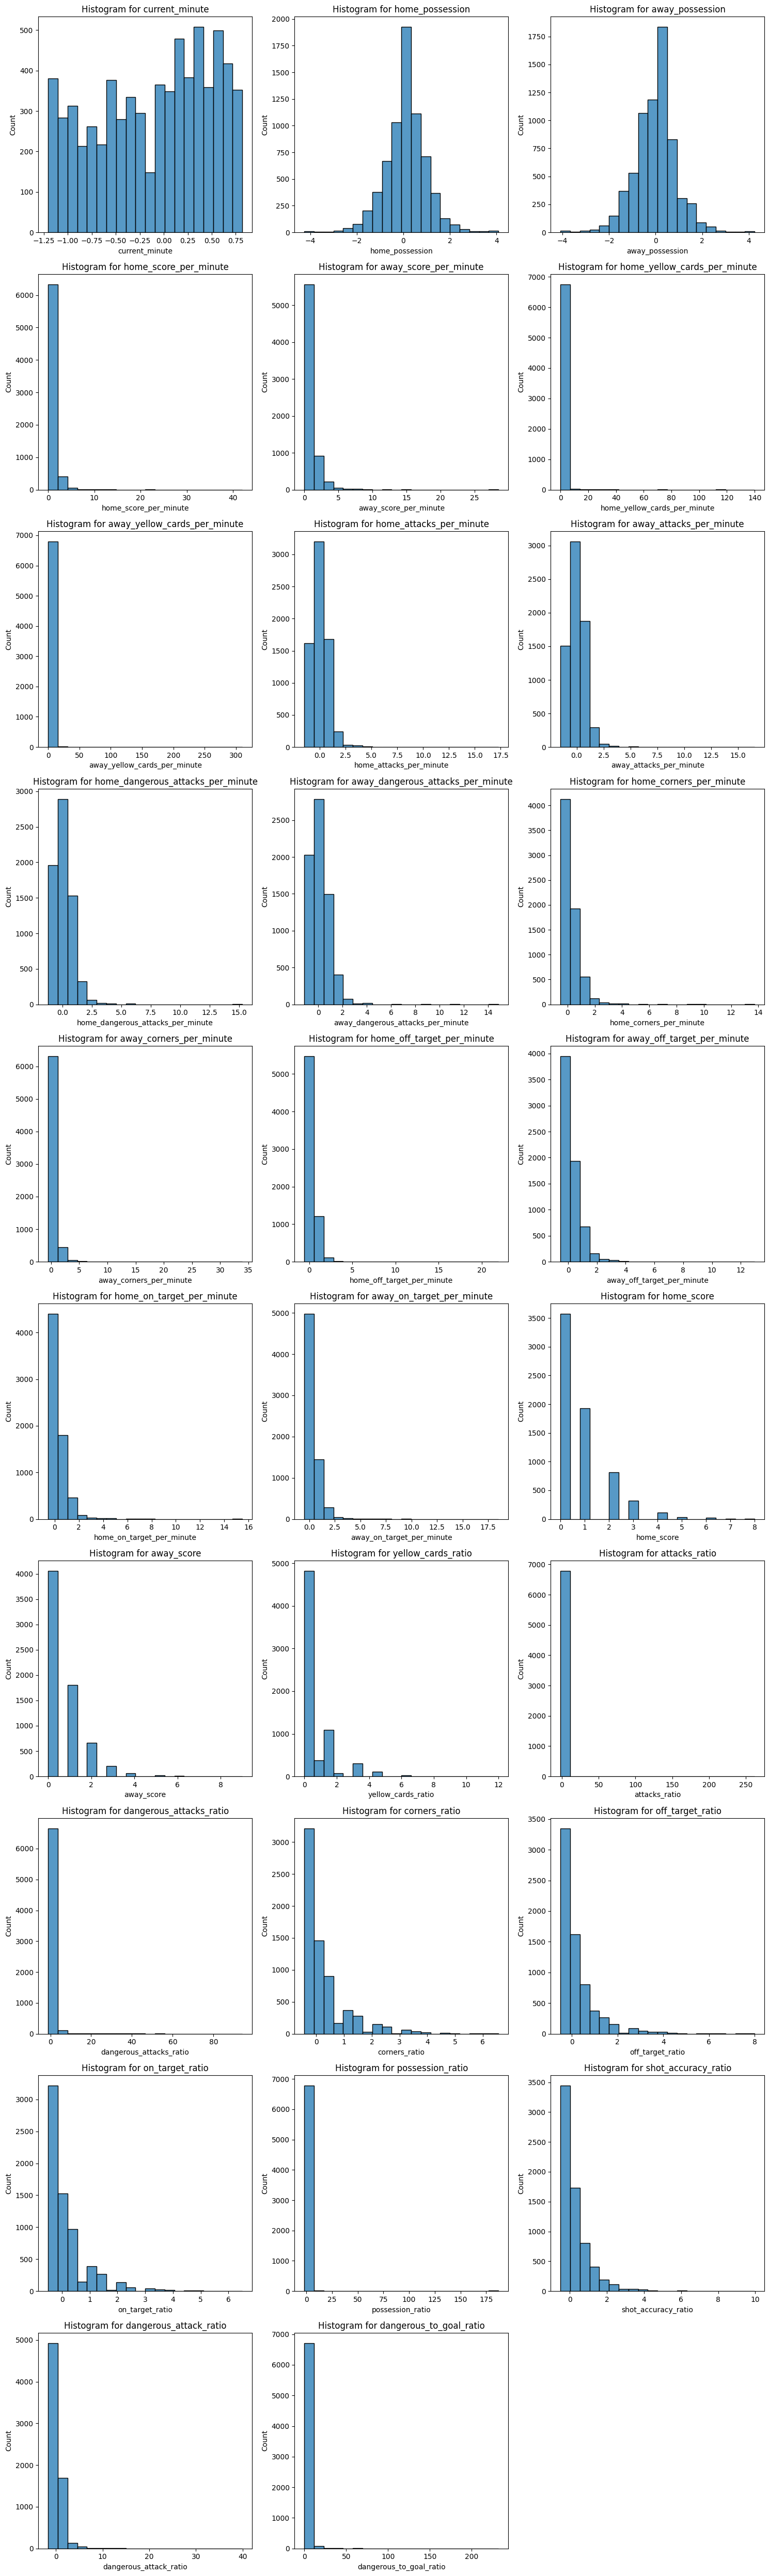

In [ ]:
import math

def HistPlot(df):
    num_columns = len(df.columns)  # 説明変数の数
    cols = 3  # 1行に3つのプロットを並べる
    rows = math.ceil(num_columns / cols)  # 必要な行数を計算

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # グリッド状にプロット
    axes = axes.flatten()  # 2Dリストを1Dに変換して簡単にループで処理

    for i, column in enumerate(df.columns):
        sns.histplot(df[column], bins=20, ax=axes[i])
        axes[i].set_title(f'Histogram for {column}')

    # 余ったサブプロットを非表示にする
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()  # レイアウト調整
    plt.show()

# 例: DataFrame 'df' に対してヒストグラムを作成

df_X_cleaned_scaled = scaler.fit_transform(df_X_cleaned)
df_X_cleaned_scaled = pd.DataFrame(df_X_cleaned_scaled, columns=df_X_cleaned.columns)

HistPlot(df_X_cleaned_scaled)

In [ ]:
# 孤立しているデータ点を一つずつ観察して, 除去の仕方を特徴量毎で考える.(時間があれば)

In [ ]:
# 最大スコアの Merged Portion データセットにおけるRidge回帰で, どの説明変数が予測に寄与したか確認したい.
# 2. 目的変数と説明変数の相関係数を見る.
# 3. 説明変数の重みを見てみる.

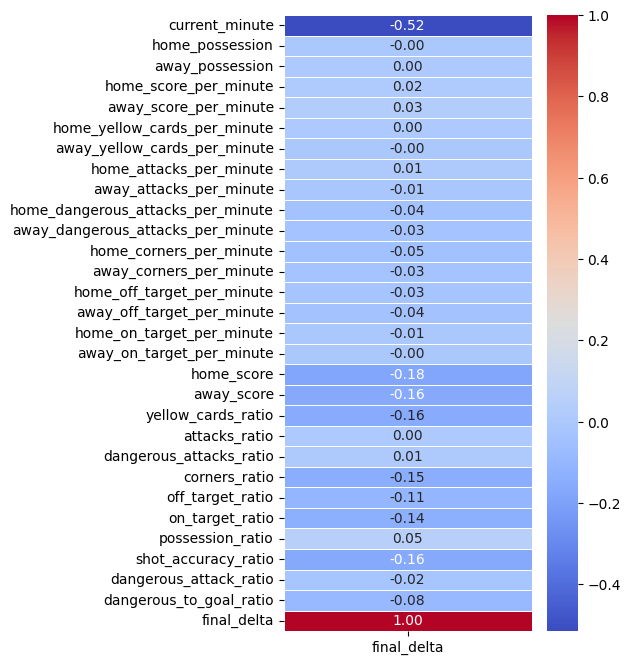

In [ ]:
# ヒートマップを描画する関数
def plot_heatmap(correlation_series, title):
    sns.heatmap(correlation_series.to_frame(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
    plt.show()

# 特徴量と目的変数のデータフレームを結合
df_combined = df_cleaned.copy()

# 目的変数との相関係数を計算
correlation_with_target = df_combined.corr()['final_delta']

# ヒートマップをsubplotで描画
fig = plt.figure(figsize=(4, 8))
plot_heatmap(correlation_with_target, 'Feature-Target Correlation Heatmap')

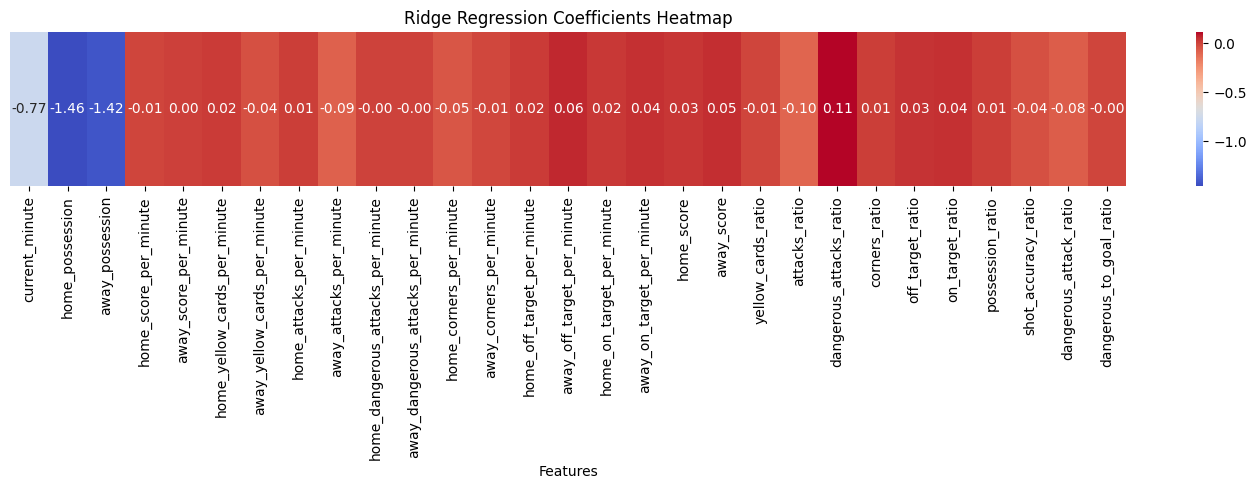

In [ ]:
# 係数の取得
ridge_coefficients = pd.DataFrame(weights.reshape(1, -1), columns=df_X_merged_portion.columns)

# ヒートマップの描画
plt.figure(figsize=(18, 2))  # サイズ調整
sns.heatmap(ridge_coefficients, cmap="coolwarm", annot=True, fmt=".2f", cbar=True)

# タイトル設定
plt.title("Ridge Regression Coefficients Heatmap")
plt.xlabel("Features")
plt.yticks([])  # y軸のラベルを消す（1行しかないため）

# 表示
plt.show()

In [ ]:
# 相関係数が0なのに, possession の重みが最大. 考察してみる. ※possessionの重みは, alphaの変化に敏感. alpha=10(alphaが大きい=制約が強い)でほぼ0.
# possession と目的変数の間に非線形な関係があるか確かめる.

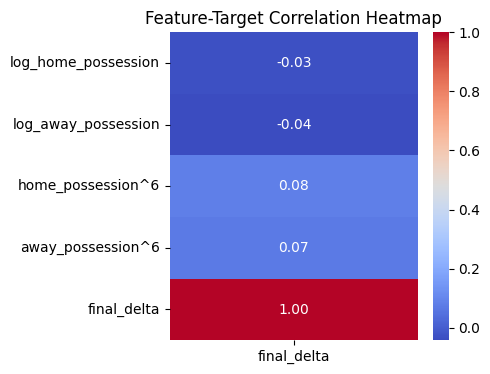

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 一時データフレームを作成
df_temp = df_cleaned.copy()

# 非線形特徴量を定義
nonlinear_columns = ['log_home_possession', 'log_away_possession', 'home_possession^6', 'away_possession^6']

# 非線形特徴量の作成
df_temp['log_home_possession'] = np.log(df_temp['home_possession'] + 1)
df_temp['log_away_possession'] = np.log(df_temp['away_possession'] + 1)
df_temp['home_possession^6'] = np.power(df_temp['home_possession'], 6)
df_temp['away_possession^6'] = np.power(df_temp['away_possession'], 6)

# 元の特徴量を削除
df_temp = df_temp.drop(['home_possession', 'away_possession'], axis=1)

# 目的変数を最後に移動
col_data = df_temp.pop('final_delta')
df_temp['final_delta'] = col_data

# 目的変数との相関係数を計算
correlation_with_target = df_temp.corr()['final_delta']

# 指定したカラムのみ抽出（nonlinear_columns + 'final_delta'）
selected_columns = nonlinear_columns + ['final_delta']
correlation_with_target = correlation_with_target.loc[selected_columns]

# ヒートマップの描画
fig = plt.figure(figsize=(4, 4))
sns.heatmap(correlation_with_target.to_frame(), cmap='coolwarm', annot=True, fmt=".2f", cbar=True)

# タイトル設定
plt.title('Feature-Target Correlation Heatmap')

# 表示
plt.show()

In [ ]:
# 累乗及びlog変換後の possession と目的変数の間に強い線形性は確認できず.
# possessionとcurrent_minuteの相関を確認する。

In [ ]:
corr_matrix = df_cleaned[['current_minute', 'home_possession', 'away_possession']].corr()
print(corr_matrix.loc['current_minute', ['home_possession', 'away_possession']])

home_possession   -0.006924
away_possession    0.006893
Name: current_minute, dtype: float64


In [ ]:
# 多重共線性は無いと言える.
# alpha に敏感であるため, possessionがfinal_deltaの予測に重要か否か評価しずらい.
# possessionを除いたデータセットで test してみる.

In [ ]:
df_no_possession = df_cleaned.copy().drop(['home_possession', 'away_possession'], axis=1)

df_X_no_possession = df_no_possession.drop('final_delta', axis=1)
df_y_no_possession = df_no_possession['final_delta']

X_no_possession = df_X_no_possession.values
y_no_possession = df_y_no_possession.values

df_results, trained_models = ProcessRegressionModels(X_no_possession, y_no_possession, 'No Possession', kfold, scaler, models)
print(df_results)

                 LinearRegression  Ridge  Lasso  PoissonRegressor
Mean Train R²               0.275  0.275  0.248             0.253
Mean Train RMSE             1.073  1.073  1.094             1.090
Mean Test R²                0.267  0.267  0.246             0.243
Mean Test RMSE              1.079  1.079  1.094             1.097


In [ ]:
# 精度変わらず. possessionは予測に寄与しないと判断.

# 続いて, 交互作用特徴量を全パターンで作成し, 目的変数と説明変数の非線形な関係を探索する.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)

df_X_polynomial = pd.DataFrame(poly.fit_transform(df_X_merged_portion), columns=poly.get_feature_names_out(df_X_merged_portion.columns))
df_y_polynomial = df_y_merged_portion.copy()

X_polynomial = df_X_polynomial.values
y_polynomial = df_y_polynomial.values

df_results, trained_models = ProcessRegressionModels(X_polynomial, y_polynomial, 'Polynomial', kfold, scaler, models)
print(df_results)

                 LinearRegression  Ridge  Lasso  PoissonRegressor
Mean Train R²               0.345  0.343  0.253             0.319
Mean Train RMSE             1.152  1.154  1.230             1.174
Mean Test R²               -3.969 -2.855  0.252        -77994.142
Mean Test RMSE              2.926  2.589  1.230           182.607


In [ ]:
# Training score 向上するも, Test score 低下
# 多重共線性の影響を排除する為, PCA適用した場合のスコアも確認してみる.
# PCAの主成分はその定義より互いに直行している. ゆえに相関は0.

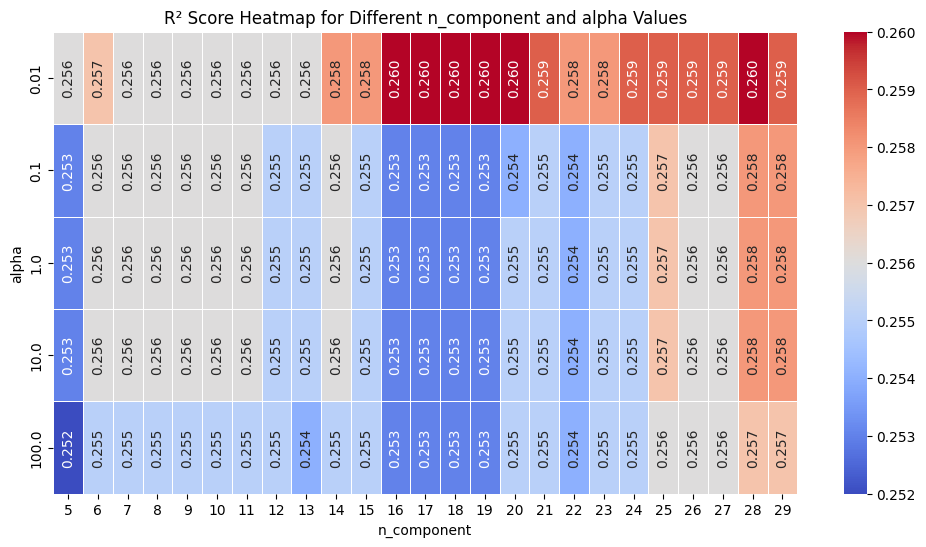

,167
n_component,16
alpha,0.01
model,PoissonRegressor
r2_score,0.26


In [ ]:
from sklearn.decomposition import PCA

# Define hyperparameter grid
param_grid = {
    'n_components': list(range(5, 30)),
    'alpha': [0.01, 0.1, 1.0, 10, 100]
}

# 結果を格納するデータフレーム
results = []

for n_component in param_grid['n_components']:
    pca = PCA(n_components=n_component, random_state=42)
    df_X_polynomial_pca = pd.DataFrame(pca.fit_transform(df_X_polynomial),
                                       columns=[f"PC{i+1}" for i in range(n_component)])

    X_polynomial_pca = df_X_polynomial_pca.values
    y_polynomial_pca = df_y_polynomial.values

    # alpha を持つモデル（Ridge, Lasso, PoissonRegressor）
    for alpha in param_grid['alpha']:

        alpha_models = {
                    "Ridge": Ridge(alpha=alpha, max_iter=2000),
                    "Lasso": Lasso(alpha=alpha, max_iter=2000),
                    "PoissonRegressor": PoissonRegressor(alpha=alpha, max_iter=2000)
                }

        df_results, trained_models = ProcessRegressionModels(X_polynomial_pca, y_polynomial_pca, 'Polynomial', kfold, scaler, alpha_models)

        for model_name in alpha_models.keys():
            r2_score = df_results.loc['Mean Test R²', model_name]
            results.append({"n_component": n_component, "alpha": alpha, "model": model_name, "r2_score": r2_score})

# 結果をデータフレームに変換
df_results = pd.DataFrame(results)

# R² スコアのヒートマップ作成
pivot_df = df_results.pivot_table(index="alpha", columns="n_component", values="r2_score", aggfunc="max") # (alpha, n_component) の組み合わせの内, 最大r2スコアのみで table を作成.

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_df, annot=True, fmt=".3f",annot_kws={"rotation": 90}, cmap="coolwarm", linewidths=0.5)
plt.title("R² Score Heatmap for Different n_component and alpha Values")
plt.xlabel("n_component")
plt.ylabel("alpha")
plt.show()

# ベストパラメータの出力
best_result = df_results.loc[df_results['r2_score'].idxmax()] # pivot_table の内, 最大r2スコアを取る
best_result

In [ ]:
# 最大r2スコアとなるような、PCAのcomponent数とモデルの正則化パラメータの組み合わせが求まった.
# df_merged_portion の方が, r2スコアが高いという結果.
# 交互作用特徴量により非線形な回帰予測が可能となった. その結果 train セットへの適合度が増加したが, test セットへの汎化性能はほとんど変化しなかった.
# ⇒ 交互作用特徴量による精度向上は確認できず.
# ⇒ 特徴量エンジニアリングについて, 思いつくこと全て試した！！限界に到達.

# Merged Portion データフレームの回帰予測の内,  current_minute 特徴量の効果がどの程度か知りたい.
# current_minute のみで回帰予測してみる.

In [ ]:
df_current_minute = df_no_anomalies.copy()
df_X_current_minute = df_current_minute['current_minute']
df_y_current_minute = df_current_minute['final_delta']

X_current_minute = df_X_current_minute.values.reshape(-1, 1)
y_current_minute = df_y_current_minute.values

df_results, trained_models = ProcessRegressionModels(X_current_minute, y_current_minute, 'Current Minute', kfold, scaler, models)
print(df_results)

                 LinearRegression  Ridge  Lasso  PoissonRegressor
Mean Train R²               0.258  0.258  0.244             0.244
Mean Train RMSE             1.226  1.226  1.237             1.237
Mean Test R²                0.257  0.257  0.243             0.243
Mean Test RMSE              1.226  1.226  1.238             1.238


In [ ]:
# r2 = 0 : 常に目的変数の平均値を予測するのと同程度の精度.(ベースライン)
# モデルごとの精度の違いについて考える.
# いずれのモデルにしても, current_minuteのみでは精度が低下することが分かる.
# Merged Portion の内, 不要な特徴量を削除していき, 予測に寄与する特徴量を絞り込んで説明性を上げる.